# Notebook for conducting the full series of experiments of creating the correlation matrix with the new metric


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from syntheval import SynthEval 

from generate_dataset import generate_synthetic_data


dataset_names = ['breast_cancer', 'cardiotocography', 'cervical_cancer', 'derm', 'diabetes', 'glass', 'hepatitis', 'kidney_disease','penguins', 'space_titanic', 'stroke', 'titanic', 'yeast']
dataset_target_variable = ['Status', 'Class', 'Biopsy', 'class', 'Outcome', 'Type', 'Baselinehistological staging', 'class', 'species', 'Transported', 'stroke', 'Embarked', 'localization_site']

generative_model_names = ['datasynthesizer', 'synthpop', 'ctgan', 'adsgan', 'tvae', 'nflow', 'ddpm', 'privbayes']

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [ ]:
### Loop over everything series

GENERATE_MISSING = False
GENERATE_OVERWRITE = False

res_df = None

for dataset_name, target_variable in zip(dataset_names, dataset_target_variable):
    df_train = pd.read_csv('real_datasets/'+ dataset_name +'_train.csv')
    df_test = pd.read_csv('real_datasets/'+ dataset_name + '_test.csv')

    SE = SynthEval(df_train, df_test, verbose=False)

    for generative_model in generative_model_names:
        try: 
            if GENERATE_OVERWRITE: raise Exception("Regenerate the synthetic datasets")
            df_syn = pd.read_csv('synt_datasets/'+ dataset_name + '_' + generative_model + '.csv')
        except:
            if not GENERATE_MISSING: continue
            df_syn = generate_synthetic_data(dataset_name, generative_model)
        
        res = SE.evaluate(df_syn, target_variable,'./full_eval.json')
        
        if res_df is None:
            res_df = pd.DataFrame(columns=res['metric'])

        res = res.set_index('metric').T

        res_df.loc[len(res_df)] = res.loc['n_val']
    
res_df.to_csv("evaluation_results.csv", index=False)

In [3]:
### Loop over everything parallel

from tqdm import tqdm
from itertools import product
from joblib import Parallel, delayed

iterables_list = list(product(zip(dataset_names, dataset_target_variable), generative_model_names))

GENERATE_MISSING = False
GENERATE_OVERWRITE = False

def work_func(iterable):
    (dataset_name,target_variable), generative_model =  iterable
    try: 
        if GENERATE_OVERWRITE: raise Exception("Regenerate the synthetic datasets")
        df_syn = pd.read_csv('synt_datasets/'+ dataset_name + '_' + generative_model + '.csv')
    except:
        if not GENERATE_MISSING: return None
        df_syn = generate_synthetic_data(dataset_name, generative_model)
    
    df_train = pd.read_csv('real_datasets/'+ dataset_name +'_train.csv')
    df_test = pd.read_csv('real_datasets/'+ dataset_name + '_test.csv')

    SE = SynthEval(df_train, df_test, verbose=False)
    res = SE.evaluate(df_syn, target_variable,'./full_eval.json')
    
    res = res.set_index('metric').T

    return res.loc['n_val']

res_list = Parallel(n_jobs=-2)(delayed(work_func)(iterable) for iterable in tqdm(iterables_list))

res_df = pd.DataFrame(columns=list(res_list[0].index))
for res, i in zip(res_list,range(len(res_list))): res_df.loc[i] = res

res_df = res_df.dropna(how='all')

res_df.to_csv("evaluation_results.csv", index=False)

100%|██████████| 104/104 [03:17<00:00,  1.89s/it]


In [4]:
def _shortened_labels(ax_get_ticks):
    max_label_length = 10
    labels = [label.get_text()[:max_label_length] + '...' if len(label.get_text()) > max_label_length else label.get_text() for label in ax_get_ticks]
    return labels

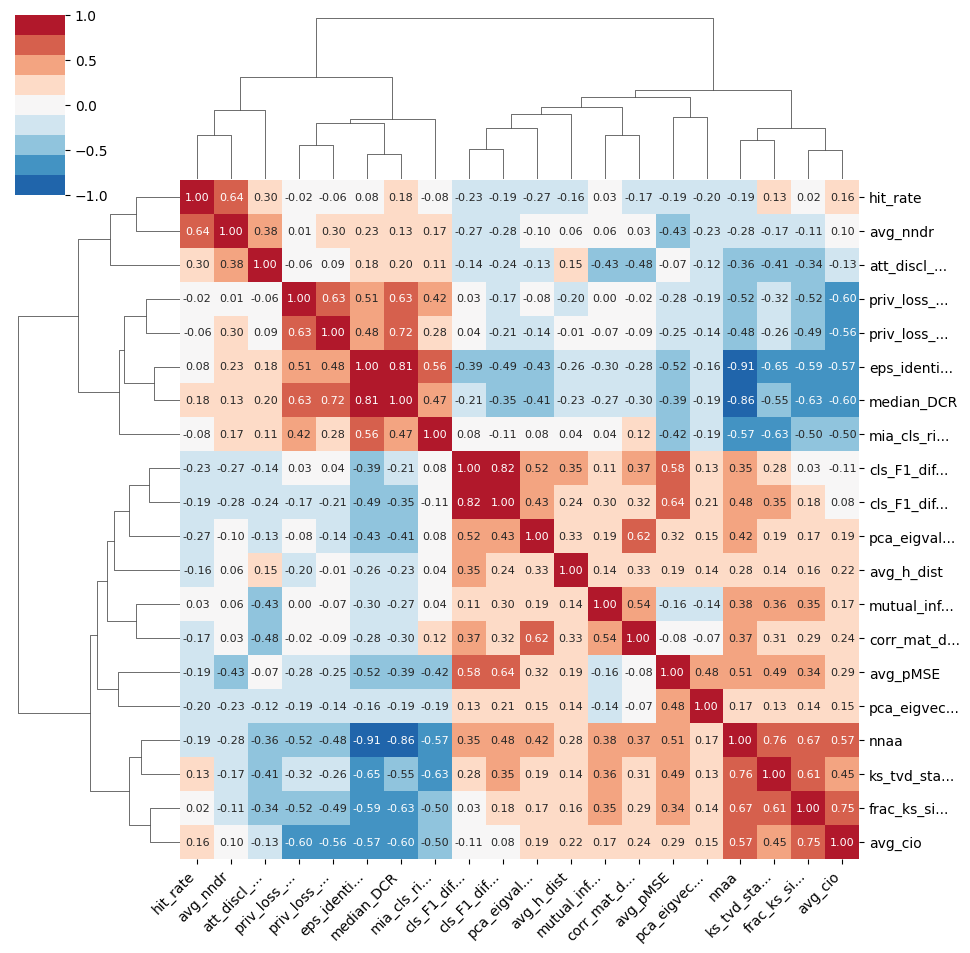

In [5]:
### Construct correlation matrix
df = pd.read_csv('evaluation_results.csv')

correlations = df.corr()

colors = sns.color_palette("RdBu_r", 9)

# fig, ax = plt.subplots(figsize=(8,8))

result = sns.clustermap(correlations, dendrogram_ratio=0.2, annot=True, fmt=".2f",annot_kws={"fontsize":8}, cmap=colors, vmin=-1, vmax=1)
result.ax_heatmap.invert_xaxis()
result.ax_heatmap.invert_yaxis()

result.ax_col_dendrogram.invert_xaxis()
result.ax_row_dendrogram.invert_yaxis()

labels = _shortened_labels(result.ax_heatmap.get_xticklabels())
result.ax_heatmap.set_xticks(result.ax_heatmap.get_xticks(), labels, rotation=45, ha='right')
result.ax_heatmap.set_yticks(result.ax_heatmap.get_yticks(), labels)

plt.savefig('corr_clust_result.pdf')
plt.show()